In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# Import csv data
df = pd.read_csv('..\\Data\\all_pitches.csv')

In [3]:
# Separate target variables
target_cols = ['call_B', 'call_C', 'call_F', 'call_H', 'call_S', 'is_out']
targets = df[target_cols]

# Separate pitch types and pitch locations
pitch_types_dummies = df.filter(regex="pitch_type_*")

# Use stack to collapse the columns into 1
pitch_types = pitch_types_dummies[pitch_types_dummies==1].stack().reset_index().drop(['level_0', 0], 1)

pitch_types.columns = ['pitch_type']

# Set strikezone divisions
# Consider importing these from Data_Wrangling in the future
sz_top = 3.406
sz_bot = 1.321
sz_right = -1.181
sz_left = 1.133
sz_top_third = 2.711
sz_bot_third = 2.016
sz_right_third = -0.410
sz_left_third = 0.362

# Split x location into zones
df.loc[df['pitch_locx'] < sz_right, 'loc_x'] = 'ballX_right'
df.loc[(df['pitch_locx'] > sz_right) & (df['pitch_locx'] < sz_right_third), 'loc_x'] = 'strikeX_right'
df.loc[(df['pitch_locx'] > sz_right_third) & (df['pitch_locx'] < sz_left_third), 'loc_x'] = 'strikeX_mid'
df.loc[(df['pitch_locx'] > sz_left_third) & (df['pitch_locx'] < sz_left), 'loc_x'] = 'strikeX_left'
df.loc[(df['pitch_locx'] > sz_left), 'loc_x']= 'ballX_left'

# Split y location into zones
df.loc[df['pitch_locy'] < sz_bot, 'loc_y'] = 'ballY_bot'
df.loc[(df['pitch_locy'] > sz_bot) & (df['pitch_locy'] < sz_bot_third), 'loc_y'] = 'strikeY_bot'
df.loc[(df['pitch_locy'] > sz_bot_third) & (df['pitch_locy'] < sz_top_third), 'loc_y'] = 'strikeY_mid'
df.loc[(df['pitch_locy'] > sz_top_third) & (df['pitch_locy'] < sz_top), 'loc_y'] = 'strikeY_top'
df.loc[(df['pitch_locy'] > sz_top), 'loc_y']= 'ballY_top'

In [4]:
# Filter out relevant columns to keep from df
eda_df = df[['batSide_des', 'pitchHand_des', 'count_balls', 'count_strikes', 'inning_num', 'pitch_speed', 'loc_x', 'loc_y']]

# Join targets, pitch_types, pitch_locs
eda_df = eda_df.join([pitch_types, targets])

In [5]:
# Group outs by batSide, pitchHand, pitch_type, pitch_loc
def heat_map(data, bat_side, pitch_types, call):
    '''Plot and return number of a certain pitch is thrown to a certain batter by a certain pitcher given the outcome call.
    Should plot two heat maps. The first is percent of outs in regards to the parameters. The second is total number of
    pitches produced the outcome call.'''
    hm_df = pd.DataFrame()
    
    for pitch in pitch_types:
        pitch_cat = 'pitch_type_' + pitch
        hm_df = hm_df.append(data[(data['batSide_des'] == bat_side) & (data['pitch_type'] == pitch_cat)])
    
    # Pivot hm_df to take average of outcome call by location
    hm_df_call = hm_df.loc[:,['loc_x', 'loc_y', call]]
    hm_pivot_mean = hm_df_call.pivot_table(index='loc_y', columns='loc_x', values=call, aggfunc='mean')
    hm_pivot_mean = hm_pivot_mean.reindex(['ballX_right', 'strikeX_right', 'strikeX_mid', 'strikeX_left', 'ballX_left'], axis=1)
    hm_pivot_mean = hm_pivot_mean.reindex(['ballY_top', 'strikeY_top', 'strikeY_mid', 'strikeY_bot', 'ballY_bot'], axis=0)
    
    # Pivot hm_df to take count of outcome call by location
    hm_df_count = hm_df[hm_df[call] == 1]
    hm_df_count = hm_df_count[['loc_x', 'loc_y', call]]
    hm_pivot_count = hm_df_count.pivot_table(index='loc_y', columns='loc_x', values=call, aggfunc='count')
    hm_pivot_count = hm_pivot_count.reindex(['ballX_right', 'strikeX_right', 'strikeX_mid', 'strikeX_left', 'ballX_left'], axis=1)
    hm_pivot_count = hm_pivot_count.reindex(['ballY_top', 'strikeY_top', 'strikeY_mid', 'strikeY_bot', 'ballY_bot'], axis=0)
    
    # Plot heatmaps for both pivoted dataframes
    _ = plt.figure(figsize=(20, 10))
    _ = plt.subplot(1, 2, 1)
    hm_pivot_mean_max = hm_pivot_mean.values.max()
    hm_pivot_mean_min = hm_pivot_mean.values.min()
    heatmap_mean_center = (hm_pivot_mean_max - hm_pivot_mean_min)/2
    _ = sns.heatmap(hm_pivot_mean, cmap = 'coolwarm', center = heatmap_mean_center)
    _ = plt.title('Percent %s by %s-Handed Batter from %s' %(call, bat_side, pitch_types))
    
    _ = plt.subplot(1, 2, 2)
    hm_pivot_count_max = hm_pivot_count.values.max()
    hm_pivot_count_min = hm_pivot_count.values.min()
    heatmap_count_center = (hm_pivot_count_max - hm_pivot_count_min)/2
    _ = sns.heatmap(hm_pivot_count, cmap = 'coolwarm', center = heatmap_count_center)
    _ = plt.title('Number of %s by %s-Handed Batter from %s' %(call, bat_side, pitch_types))
    _ = plt.tight_layout()
    _ = plt.show()
    
    return hm_pivot_mean, hm_pivot_count

In [6]:
# Create a function to do t-testing
def t_testing(eda_data, bat_side, pitch_types, call, locx_zone, locy_zone, alpha = 0.05):
    '''This function will test if a pitch_type in location locx_zone and locy_zone to a bater of bat_side produces a significant
    difference in means to a typical pitch at the same location to the same bat_side'''
    pitch_type_list = []
    all_pitches_by_call = pd.Series()
    testing_series = pd.Series()
    
    # Need to append label to pitches in pitch_type
    for pitch in pitch_types:
        pitch_cat = 'pitch_type_' + pitch
        pitch_type_list.append(pitch_cat)
        
        # Create a series with pitches in pitch_type
        testing_series = testing_series.append(eda_data[(eda_data['batSide_des'] == bat_side) & (eda_data['loc_x'].isin(locx_zone)) & (eda_data['loc_y'].isin(locy_zone)) & (eda_data['pitch_type'] == pitch_cat)][call])
    
    # Create a series excluding pitches in pitch_type
    all_pitches_by_call = all_pitches_by_call.append(eda_data[(eda_data['batSide_des'] == bat_side) & (eda_data['loc_x'].isin(locx_zone)) & (eda_data['loc_y'].isin(locy_zone)) & ~(eda_data['pitch_type'].isin(pitch_type_list))][call])
    print("Total pitches: %i. Mean %s: %f." %(len(all_pitches_by_call), call, all_pitches_by_call.mean()))
    print("Total %s: %i. Mean %s: %f." %(pitch_types, len(testing_series), call, testing_series.mean()))
    
    # Perform a t-test on the two series
    t_stat, p_val = stats.ttest_ind(all_pitches_by_call, testing_series, equal_var = False)
    
    # Print a statement depending on resulting p-value
    if p_val > alpha:
        print("There's no statistical significance for getting %s against %s-handed batters by throwing a %s at %s and %s" %(call, bat_side, pitch_types, locx_zone, locy_zone))
        print("Test statistic: %f. P-value: %f" %(t_stat, p_val))
    else:
        print("There's a statistical significance for getting %s against %s-handed batters by throwing a %s at %s and %s opposed to other pitches" %(call, bat_side, pitch_types, locx_zone, locy_zone))
        print("Test statistic: %f. P-value: %f" %(t_stat, p_val))

In [7]:
# Create a list of hard pitches
hard_stuff = ['Four-Seam Fastball', 'Two-Seam Fastball', 'Fastball']

# Create a list of soft pitches
soft_stuff = ['Curveball', 'Changeup', 'Splitter']

# Create a list of mistake pitches
mistake_pitches = ['Changeup', 'Curveball', 'Slider', 'Splitter', 'Sinker']

In [8]:
loc_up = ['strikeY_top', 'strikeY_mid']
strikeX_zone = ['strikeX_right', 'strikeX_mid', 'strikeX_left']

# MLB Batting Tendencies

By: Curtis Higa

## Pitcher's Dilemma
+ Starting pitchers pitch once every 5 days
    + Typically last 6 innings
+ Relief pitchers can pitch in multiple games in a row
    + Typically don't pitch more than 2 innings
+ Pitchers get paid the same as everyday players

## Pitcher's Dilemma (cont.d)
+ Studies to prevent pitcher injuries
    + Pitch count limitations
    + Pitchers most effecttive 20-70 pitches into game
+ Doesn't solve how to maximize pitcher efficiency

## Pitcher Efficiency
+ Want to maximize wins without spending too much
$$Dollars\:per\:win = \frac{\sum(Player\:Salaries)}{Total\:Wins}$$
$$\approx \frac{\sum(Player\:Salaries)}{Runs\:Scored - Runs\:Allowed}$$

$$Runs\:Allowed \approx ERA \approx \frac{Runs}{Innings\:Pitched}$$
$$= \frac{3 \times Runs}{Number\:of\:Outs}$$

+ More outs per pitches thrown

## Batting Tendencies
+ Many idioms about how to pitch
    + "Hard stuff in, soft stuff away"
    + Breaking pitches up

## "Hard stuff in..."
### Right-Handed Batter

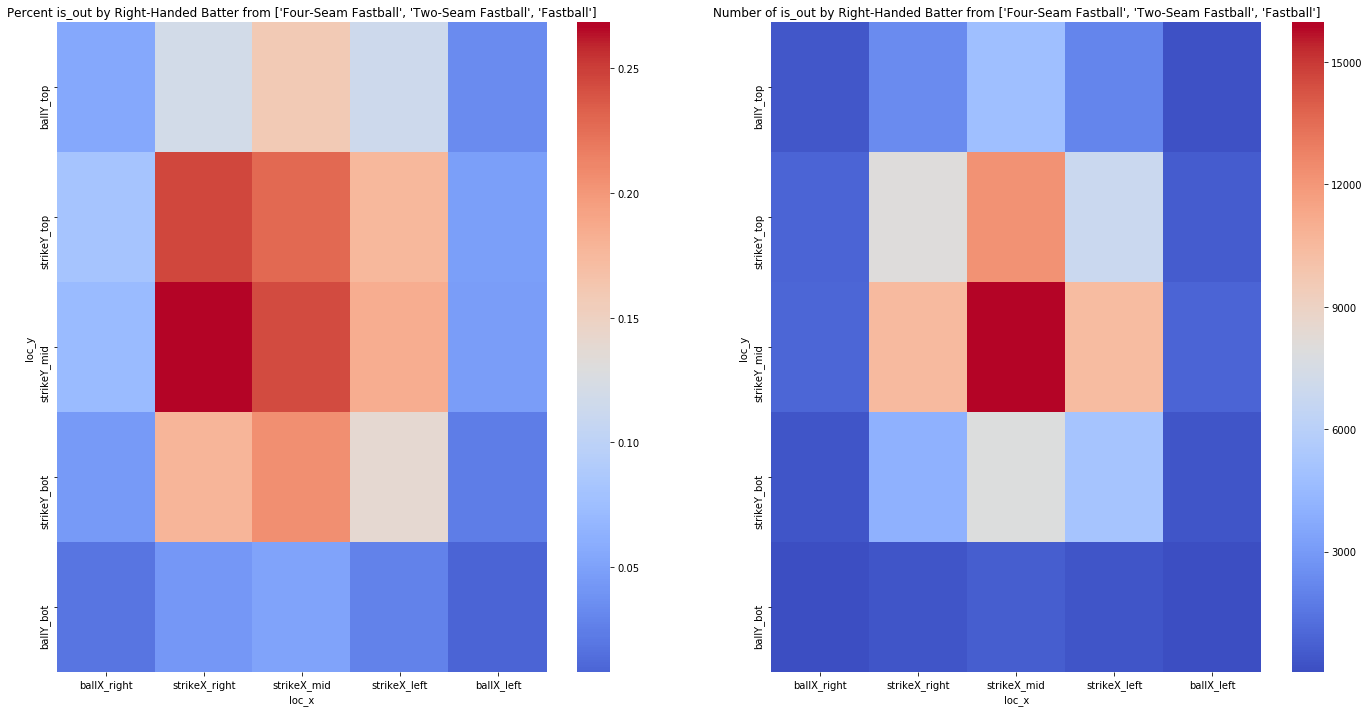

In [9]:
# Plot a heatmap for hard stuff to right-handed batters
hs_right_outs_mean, hs_right_outs_count = heat_map(eda_df,
                                                   bat_side = 'Right',
                                                   pitch_types = hard_stuff,
                                                   call='is_out')

## "Hard stuff in..." (cont.d)
### Left-Handed Batter

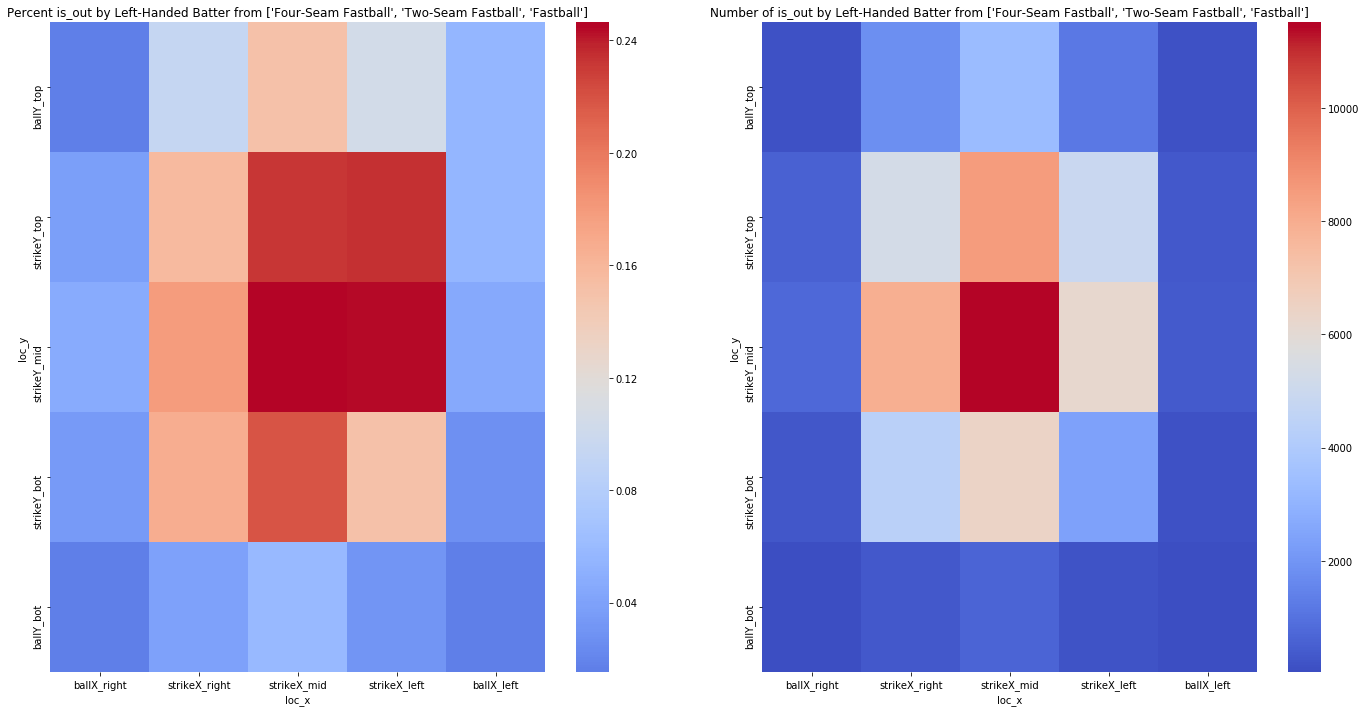

In [10]:
# Plot a heatmap for hard stuff to left-handed batters
hs_left_outs_mean, hs_left_outs_count = heat_map(eda_df,
                                                 bat_side = 'Left',
                                                 pitch_types = hard_stuff,
                                                 call = 'is_out')

## "Hard stuff in..." (cont.d)

In [11]:
# Test the significance of hard stuff in to right-handed batters
t_testing(eda_df,
          bat_side = 'Right',
          pitch_types = hard_stuff, 
          call = 'is_out', 
          locx_zone = ['strikeX_right'],
          locy_zone = ['strikeY_mid', 'stikeY_top', 'strikeY_bot'])

Total pitches: 57316. Mean is_out: 0.209209.
Total ['Four-Seam Fastball', 'Two-Seam Fastball', 'Fastball']: 61592. Mean is_out: 0.235485.
There's a statistical significance for getting is_out against Right-handed batters by throwing a ['Four-Seam Fastball', 'Two-Seam Fastball', 'Fastball'] at ['strikeX_right'] and ['strikeY_mid', 'stikeY_top', 'strikeY_bot'] opposed to other pitches
Test statistic: -10.901779. P-value: 0.000000


In [12]:
# Test the significance of hard stuff in to left-handed batters
t_testing(eda_df,
          bat_side='Left',
          pitch_types=['Four-Seam Fastball', 'Two-Seam Fastball', 'Fastball'],
          call = 'is_out',
          locx_zone=['strikeX_left'], 
          locy_zone=['strikeY_mid', 'stikeY_top', 'strikeY_bot'])

Total pitches: 43117. Mean is_out: 0.196883.
Total ['Four-Seam Fastball', 'Two-Seam Fastball', 'Fastball']: 41219. Mean is_out: 0.208569.
There's a statistical significance for getting is_out against Left-handed batters by throwing a ['Four-Seam Fastball', 'Two-Seam Fastball', 'Fastball'] at ['strikeX_left'] and ['strikeY_mid', 'stikeY_top', 'strikeY_bot'] opposed to other pitches
Test statistic: -4.218988. P-value: 0.000025


## "Hard stuff in..." (cont.d)
+ Statistical difference in means
+ May not have practical significance
    + Hard stuff is most commonly pitched

## "... Soft stuff away"
### Right-handed batters

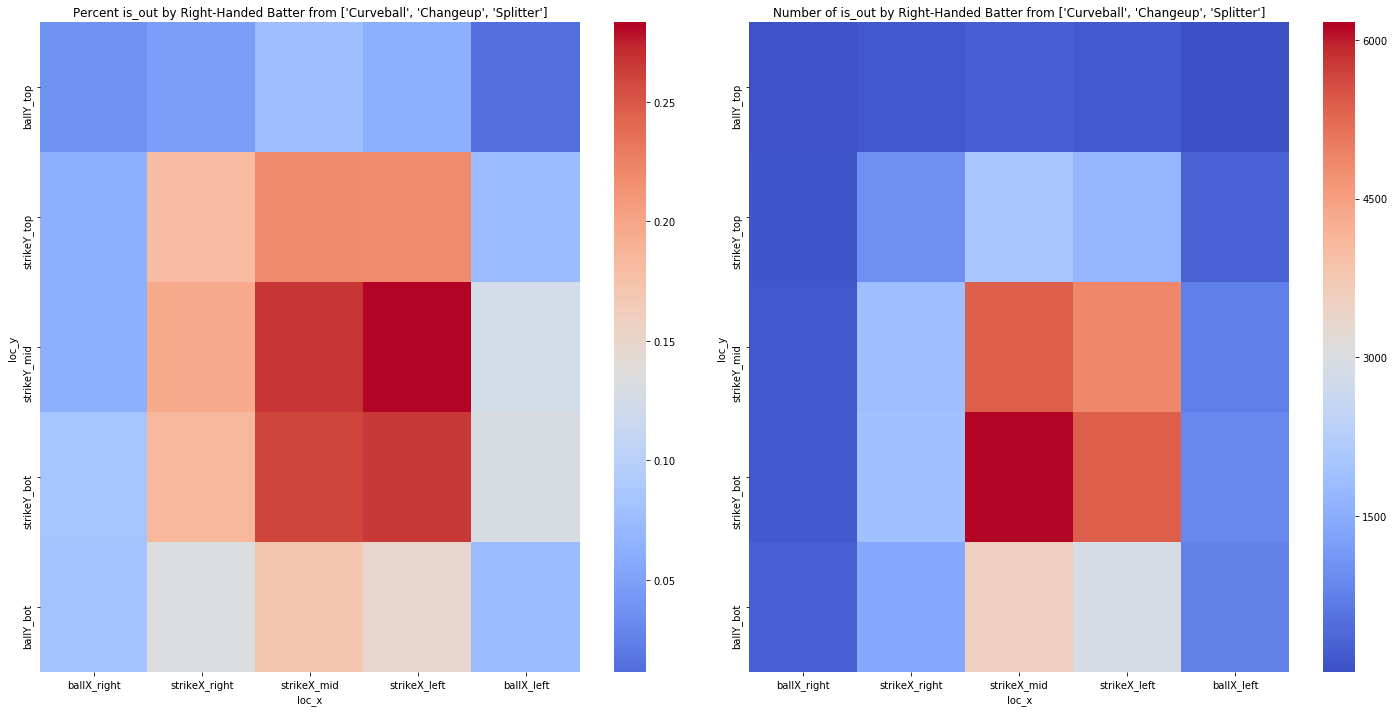

In [13]:
ss_right_outs_mean, ss_right_outs_count = heat_map(eda_df,
                                                   'Right',
                                                   soft_stuff,
                                                   'is_out')

## "...Soft stuff away" (cont.d)
### Left-handed batters

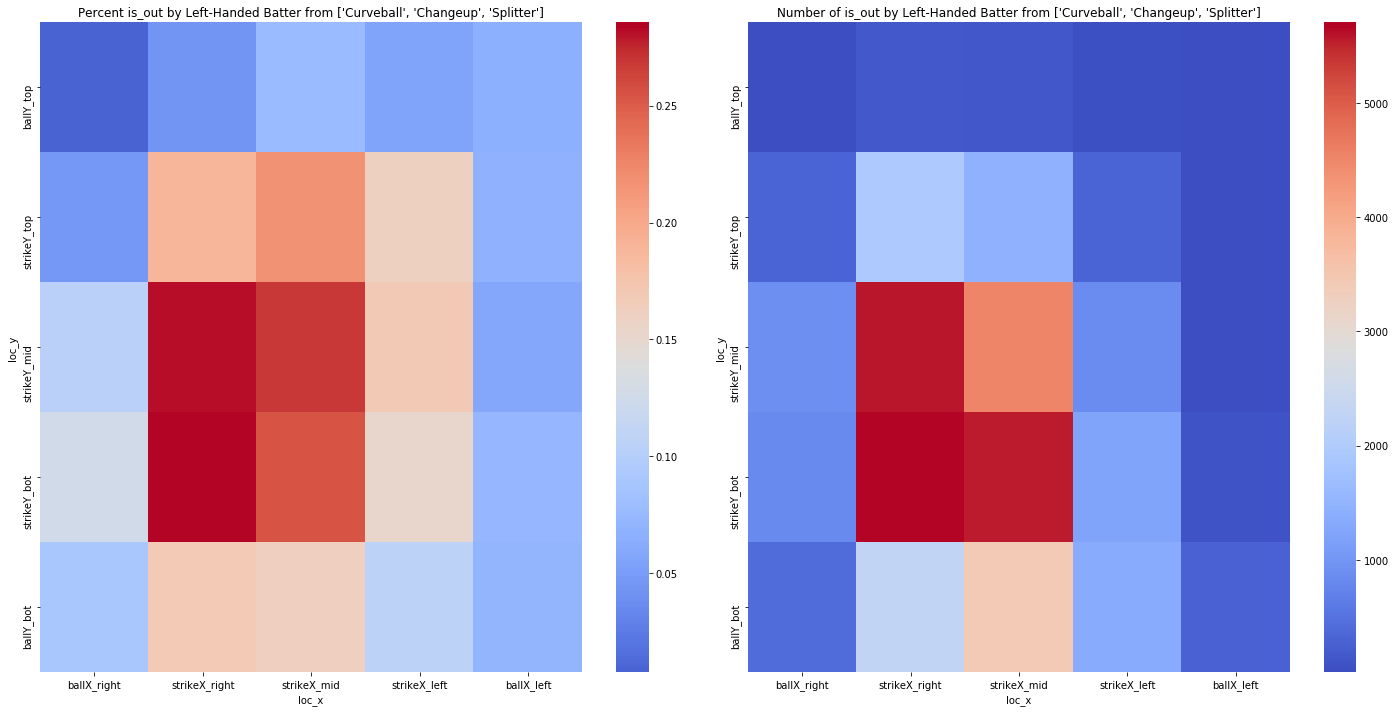

In [14]:
ss_left_outs_mean, ss_left_outs_count = heat_map(eda_df,
                                                 bat_side = 'Left',
                                                 pitch_types = soft_stuff,
                                                 call = 'is_out')

## "...Soft stuff away" (cont.d)

In [15]:
t_testing(eda_df,
         bat_side = 'Right',
         pitch_types = soft_stuff,
         locx_zone = ['strikeX_left'],
         locy_zone = ['strikeY_mid', 'strikeY_bot'],
         call = 'is_out')

Total pitches: 175662. Mean is_out: 0.197766.
Total ['Curveball', 'Changeup', 'Splitter']: 37387. Mean is_out: 0.273972.
There's a statistical significance for getting is_out against Right-handed batters by throwing a ['Curveball', 'Changeup', 'Splitter'] at ['strikeX_left'] and ['strikeY_mid', 'strikeY_bot'] opposed to other pitches
Test statistic: -30.546849. P-value: 0.000000


In [16]:
t_testing(eda_df,
         bat_side = 'Left',
         pitch_types = soft_stuff,
         locx_zone = ['strikeX_right'],
         locy_zone = ['strikeY_mid', 'strikeY_bot'],
         call = 'is_out')

Total pitches: 111058. Mean is_out: 0.193782.
Total ['Curveball', 'Changeup', 'Splitter']: 39774. Mean is_out: 0.283778.
There's a statistical significance for getting is_out against Left-handed batters by throwing a ['Curveball', 'Changeup', 'Splitter'] at ['strikeX_right'] and ['strikeY_mid', 'strikeY_bot'] opposed to other pitches
Test statistic: -35.253647. P-value: 0.000000


## "...Soft stuff away" (cont.d)
+ Statistical difference in means
+ Practical significance
    + 8% for right-handers, 9% for left-handers

## Mistakes Up
### Right-handed batters

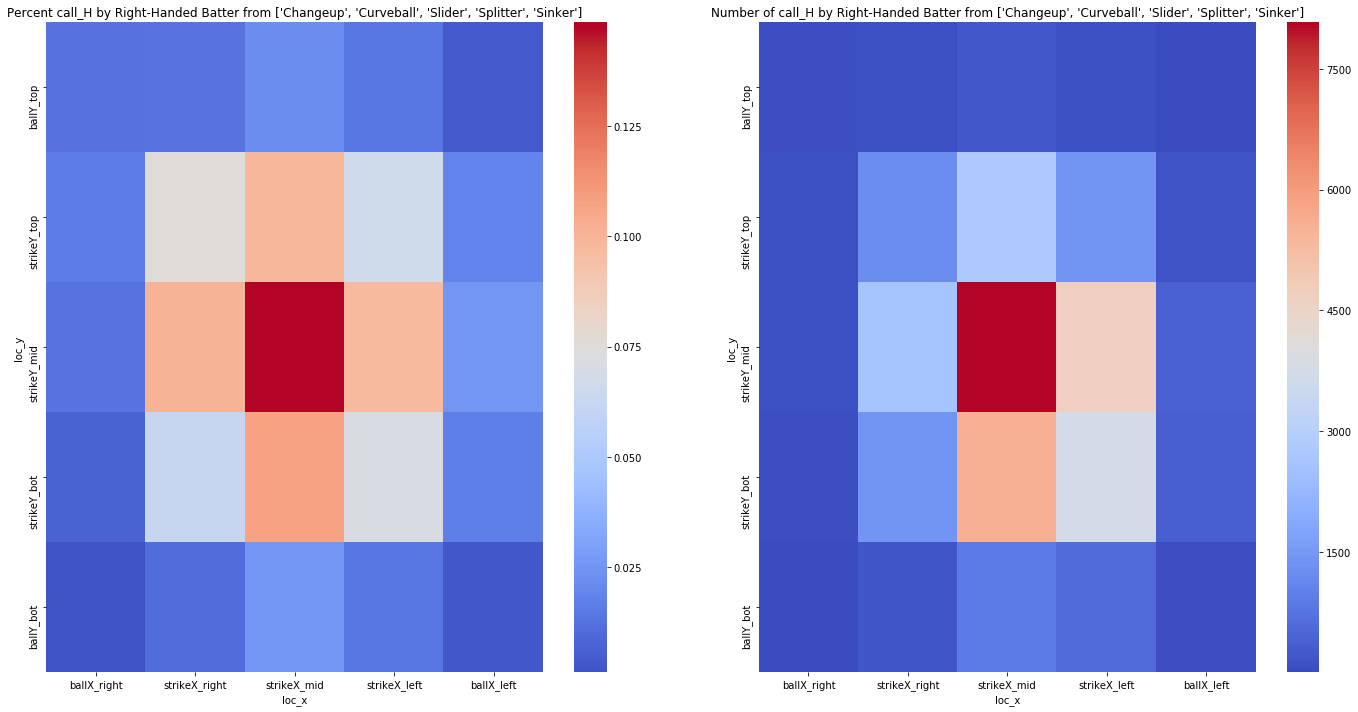

In [17]:
mistakes_right_hit_mean, mistakes_right_hit_count = heat_map(eda_df,
                                                             bat_side = 'Right',
                                                             pitch_types = mistake_pitches,
                                                             call = 'call_H')

## Mistakes Up (cont.d)
### Left-handed batters

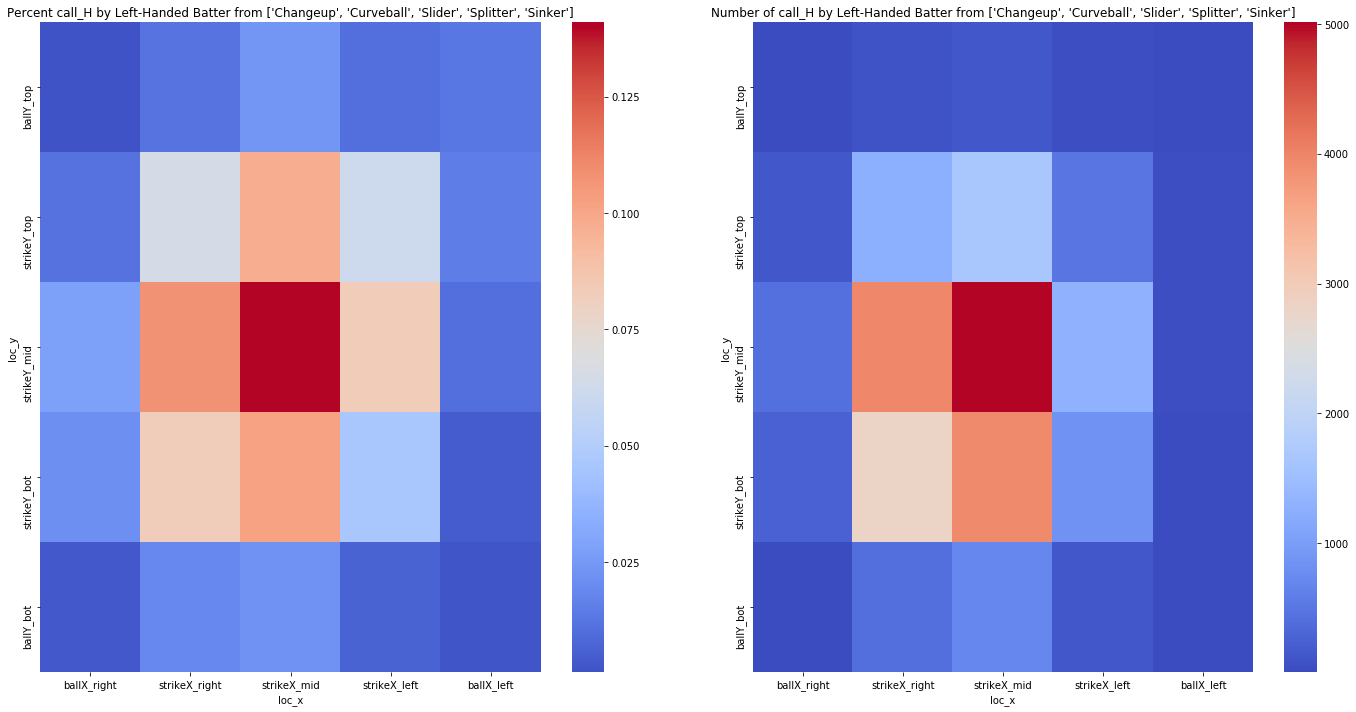

In [18]:
mistakes_left_hit_mean, mistakes_left_hit_count = heat_map(eda_df,
                                                           bat_side = 'Left',
                                                           pitch_types = mistake_pitches,
                                                           call = 'call_H')

## Mistakes Up (cont.d)

In [19]:
t_testing(eda_df, 
         bat_side = 'Right',
         pitch_types = mistake_pitches,
         call = 'call_H',
         locx_zone = strikeX_zone,
         locy_zone = loc_up)

Total pitches: 326217. Mean call_H: 0.099881.
Total ['Changeup', 'Curveball', 'Slider', 'Splitter', 'Sinker']: 194131. Mean call_H: 0.107015.
There's a statistical significance for getting call_H against Right-handed batters by throwing a ['Changeup', 'Curveball', 'Slider', 'Splitter', 'Sinker'] at ['strikeX_right', 'strikeX_mid', 'strikeX_left'] and ['strikeY_top', 'strikeY_mid'] opposed to other pitches
Test statistic: -8.141250. P-value: 0.000000


In [20]:
t_testing(eda_df, 
         bat_side = 'Left',
         pitch_types = mistake_pitches,
         call = 'call_H',
         locx_zone = strikeX_zone,
         locy_zone = loc_up)

Total pitches: 237468. Mean call_H: 0.096194.
Total ['Changeup', 'Curveball', 'Slider', 'Splitter', 'Sinker']: 132641. Mean call_H: 0.103309.
There's a statistical significance for getting call_H against Left-handed batters by throwing a ['Changeup', 'Curveball', 'Slider', 'Splitter', 'Sinker'] at ['strikeX_right', 'strikeX_mid', 'strikeX_left'] and ['strikeY_top', 'strikeY_mid'] opposed to other pitches
Test statistic: -6.895932. P-value: 0.000000


## Mistakes Up (cont.d)
+ Statistical difference in means
+ Practical significance questionable
    + Possible difference in game impact
        + Bases allotted
        + Groundball vs. flyball